In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib 
from matplotlib import pyplot as plt
import boto3
import os.path as op
import nibabel as nib
import AFQ.data as afd

/Users/arokem/.virtualenvs/dki/lib/python3.7/site-packages/dipy/stats/__init__.py:7: UserWarning: The `dipy.stats` module is still under heavy development and functionality, as well as the API is likely to change in future versions of the software
  warnings.warn(w_string)


In [2]:
import pandas as pd
import seaborn as sns

In [3]:
import s3fs

In [4]:
subjects = [int(s) for s in np.loadtxt('./hcp900.txt')]

In [5]:
boto3.setup_default_session(profile_name='escience')
# s3 = boto3.resource('s3')
# bucket = s3.Bucket('arokem-hcp-dki')
bucket = 'arokem-hcp-dki'

In [6]:
fs = s3fs.S3FileSystem()

In [7]:
fname = 'cod_medians.csv'
if not op.exists(fname):
    dki_medians = []
    dti_medians = []
    dti1000_medians = []
    subject_ids = []
    for subject in subjects:
        try:
            path_dki = '%s/%s/%s_cod_dki.nii.gz' % (bucket, subject, subject)
            path_dti = '%s/%s/%s_cod_dti.nii.gz' % (bucket, subject, subject)
            path_dti_1000 = '%s/%s/%s_cod_dti_1000.nii.gz' % (bucket, subject, subject)
            path_wm = '%s/%s/%s_white_matter_mask.nii.gz' % (bucket, subject, subject)
            mask = afd.s3fs_nifti_read(path_wm, fs).get_fdata().astype(bool)
            cod_dki = afd.s3fs_nifti_read(path_dki).get_fdata()[mask]
            cod_dti = afd.s3fs_nifti_read(path_dti).get_fdata()[mask]
            cod_dti_1000 = afd.s3fs_nifti_read(path_dti_1000).get_fdata()[mask]
            median_dki = np.nanmedian(cod_dki)
            median_dti = np.nanmedian(cod_dti)
            median_dti_1000 = np.nanmedian(cod_dti_1000)
            dki_medians.append(median_dki)
            dti_medians.append(median_dti)
            dti1000_medians.append(median_dti_1000)
            subject_ids.append(subject)  
            print("Subject %s works fine!" % subject)
        except Exception as err:
            print("Subject %s seems to have issues" % subject)
            print(err.args)
        
    df = pd.DataFrame(np.array([dti_medians, dki_medians, dti1000_medians]).T, columns=["DTI", "DKI", "DTI1000"], index=subject_ids)
    df.to_csv(fname)
else:
    df = pd.read_csv(fname, index_col=0)
    dti_medians = df["DTI"]
    dki_medians = df["DKI"]

In [8]:
sns.set(style="whitegrid")

In [9]:
from scipy import stats

In [10]:
stats.kruskal(df["DKI"], df["DTI1000"]), stats.kruskal(df["DKI"], df["DTI"])

(KruskalResult(statistic=5.718538393148265, pvalue=0.016786698845219196),
 KruskalResult(statistic=1173.3954736097357, pvalue=3.691976136367768e-257))

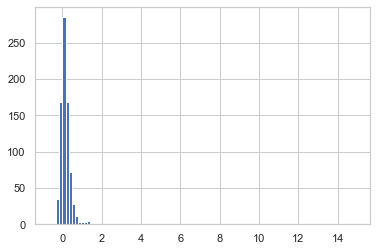

In [11]:
_ = plt.hist(df["DKI"]-df["DTI1000"], bins=100)

In [12]:
import matplotlib

In [13]:
font = {'size'  : 14}
matplotlib.rc('font', **font)

In [14]:
def plot_cod(cod1, cod2, label):
    fig, ax = plt.subplots()
    gs = gridspec.GridSpec(2, 2, width_ratios=[3,1], height_ratios=[3,1])
    ax = plt.subplot(gs[0,0])
    axx = plt.subplot(gs[1,0], sharex=ax)
    axy = plt.subplot(gs[0,1])
    ax.plot(cod1, cod2, 'o', alpha=0.5)
    axx.hist(cod1, bins=40, histtype='step', linewidth=2)
    axy.hist(cod2, bins=40, histtype='step', linewidth=2, orientation='horizontal')
    ax.plot([80, 100], [80, 100], 'k--')
    ax.set_ylabel('$R^2$ (DKI)', fontdict=font)
    axx.set_xlabel('$R^2$ (DTI)', fontdict=font)
    axx.set_ylabel('# subjects', fontdict=font)
    axy.set_xlabel('# subjects', fontdict=font)
    ax.set_yticks([80, 85, 90, 95, 100])
    ax.set_yticklabels([80, 85, 90, 95, 100], fontdict=font)
    axy.set_yticklabels('')
    ax.set_xlim([80, 100])
    ax.set_ylim([80, 100])
    axy.set_ylim([80, 100])
    axy.set_yticks([80, 85, 90, 95, 100])
    axy.set_yticklabels([80, 85, 90, 95, 100], fontdict=font)
    axy.set_xticks([0, 100, 200])
    ax.text(-0.1, 1.1, label, transform=ax.transAxes, fontdict={"size":18, "weight":"bold"})   
    fig.set_size_inches([6, 6])    
    plt.tight_layout()
    fig.savefig(f"/Users/arokem/Downloads/{label}.png")
    return fig

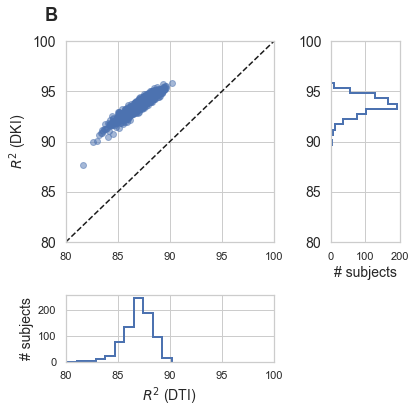

In [15]:
_ = plot_cod(df["DTI"], dki_medians, "B")

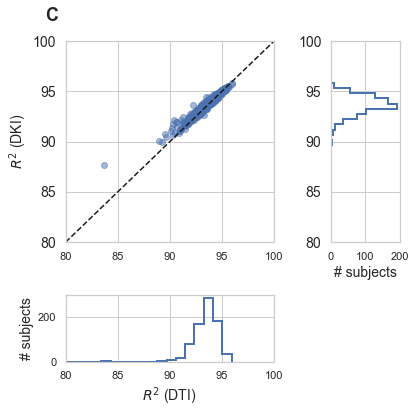

In [16]:
_= plot_cod(df["DTI1000"], dki_medians, label="C")

In [17]:
len(dti_medians)

788

In [18]:
dti_arr = np.array(dti_medians)
dki_arr = np.array(dki_medians)

In [19]:
np.min(dti_arr), np.min(dki_arr)

(53.64851599155597, 75.08040343229172)

In [20]:
df["DTI"].argmin()

/Users/arokem/.virtualenvs/dki/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  """Entry point for launching an IPython kernel.


105014

In [21]:
np.random.seed(2020)

In [22]:
subject = np.random.choice(subjects)
print(subject)

917558


In [23]:
path_dki = '%s/%s/%s_cod_dki.nii.gz' % (bucket, subject, subject)
path_dti = '%s/%s/%s_cod_dti.nii.gz' % (bucket, subject, subject)
path_wm = '%s/%s/%s_white_matter_mask.nii.gz' % (bucket, subject, subject)
mask = afd.s3fs_nifti_read(path_wm, fs).get_fdata().astype(bool)
cod_dki = afd.s3fs_nifti_read(path_dki).get_fdata()[mask]
cod_dti = afd.s3fs_nifti_read(path_dti).get_fdata()[mask]


In [24]:
cod_dti = cod_dti[cod_dti>0]
cod_dki = cod_dki[cod_dki>0]

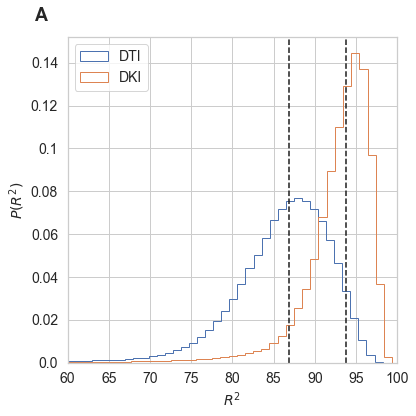

In [25]:
fig, ax = plt.subplots()
ax.hist(cod_dti, bins=100, histtype='step', label="DTI", density=True)
ax.hist(cod_dki, bins=100, histtype='step', label="DKI", density=True)
yticks = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14]
ax.set_xlabel('$R^2$', fontdict=font)
ax.set_ylabel('$P(R^2)$', fontdict=font)
ax.set_xticks([60, 65, 70, 75, 80, 85, 90, 95, 100])
ax.set_xticklabels([60, 65, 70, 75, 80, 85, 90, 95, 100], fontdict=font)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontdict=font)
ax.set_xlim([60, 100])
ax.legend(loc="upper left", fontsize=14)

plt.axvline(x=np.median(cod_dti), ymin=0, ymax=10, linestyle='--', color='k')
plt.axvline(x=np.median(cod_dki), ymin=0, ymax=10, linestyle='--', color='k')
ax.text(-0.1, 1.05, "A", transform=ax.transAxes, fontdict={"size":18, "weight":"bold"})   

# ax.set_ylim([80, 100])
# axy.set_ylim([80, 100])
# axy.set_yticks([80, 85, 90, 95, 100])
# axy.set_xticks([0, 100, 200])
fig.set_size_inches([6, 6])
plt.tight_layout()
fig.savefig(f"/Users/arokem/Downloads/A.png")
